---
title: "ML classic"
author: "rafa sacaan"
date: "2024-02-10"
categories: [prediction]
format:
  html:
    code-fold: true
jupyter: ml
draft: true
---

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np

np.random.seed(42)

# EDA

Get data and split

In [8]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Get data
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [9]:
display(X_train.head())
display(y_train)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
999,3,"McCarthy, Miss. Catherine 'Katie'",female,NaN,0,0,383123,7.7500,NaN,Q
392,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1,0,SC/PARIS 2167,27.7208,NaN,C
628,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S
1165,3,"Saad, Mr. Khalil",male,25.0,0,0,2672,7.2250,NaN,C
604,3,"Abelseth, Miss. Karen Marie",female,16.0,0,0,348125,7.6500,NaN,S


999     1
392     1
628     0
1165    0
604     1
       ..
1290    1
1103    0
755     0
530     0
668     0
Name: survived, Length: 1047, dtype: category
Categories (2, object): ['0', '1']

Check missing values

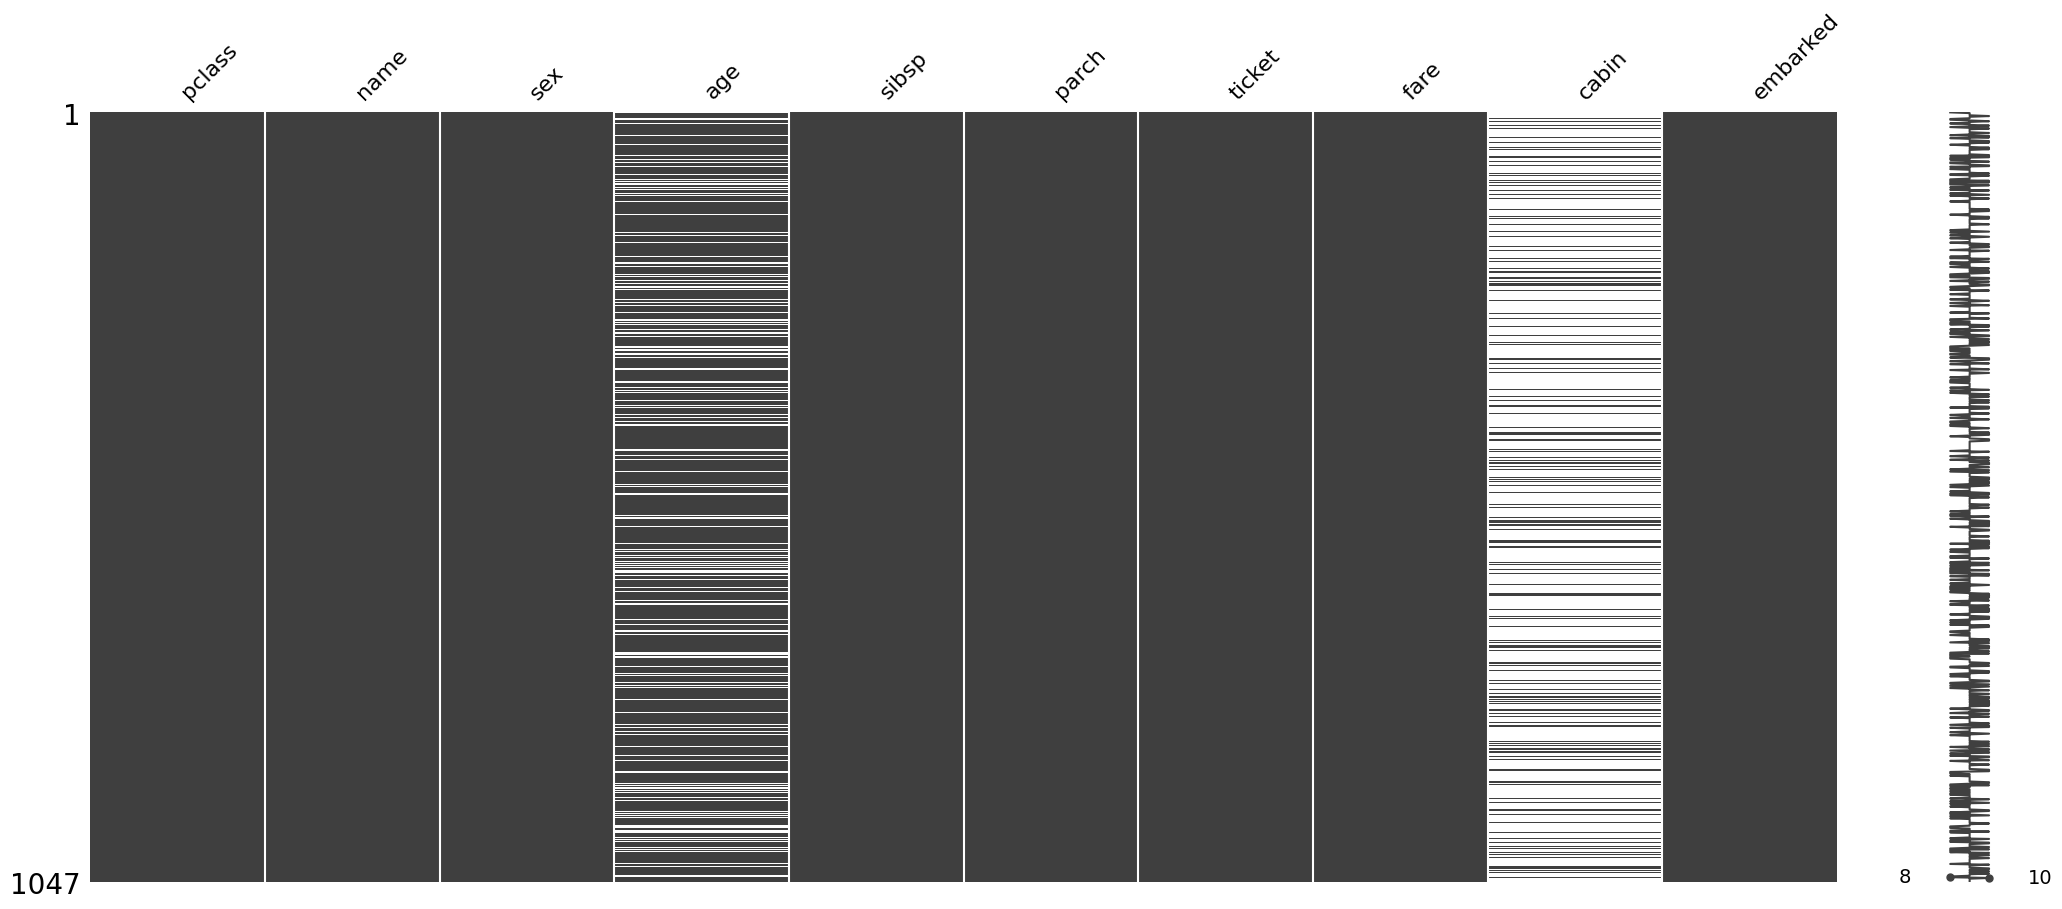

In [11]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(X_train);

In [12]:
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         19.961796
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.095511
cabin       78.510029
embarked     0.000000
dtype: float64

In [ ]:
X_train.drop(['cabin'], axis=1, inplace=True)
X_test.drop(['cabin'], axis=1, inplace=True)

## Feature eng and transformations

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

def add_features(df):
    # Example: adding a new feature representing the total sales
    df['total_sales'] = df['quantity'] * df['unit_price']
    
    # You can add more feature engineering steps here...
    
    return df

def preprocess_data(df):
    # Example: handling missing values by imputing with the mean
    imputer = SimpleImputer(strategy='mean')
    df_filled = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # You can add more preprocessing steps here...
    
    return df_filled

def encode_variables(df):
    # Example: encoding categorical variables using LabelEncoder
    label_encoders = {}
    for col in df.select_dtypes(include='object'):
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
    
    # You can add more encoding methods here...
    
    return df

# Example usage:
# Load your dataset
df = pd.read_csv('your_dataset.csv')

# Feature engineering
df = add_features(df)

# Data preprocessing
df = preprocess_data(df)

# Encoding variables
df = encode_variables(df)

# Optionally, you can scale numerical features
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


# Run modelling

In [ ]:
# Select default hyper-parameters
DEFAULT_PARAMS = {
    'objective': 'multiclass', # for classification
    'num_class': 5, # for calssification
    'categorical_feature': cat_cols,
    'learning_rate': 0.005,
    'seed': 42,
    'verbosity': -1,
    'bagging_freq': 1,
}

# Define cross validation splits
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=2112)

# Create optuna study
study = optuna.create_study(
    study_name='lgbm-ws-backtest',
    direction='maximize',
    storage='sqlite:///../../models/20240205-backtest.db',
    load_if_exists=False,
)

# Run optimization until timeout/trial is met
study.optimize(
    lambda trial: objective(
        trial=trial,
        default_params=DEFAULT_PARAMS,
        X_train=X_train,
        y_train=y_train,
        cv=sgkf,
        groups=df.loc[X_train.index, 'id'].values,
    ),
    n_trials=10000,
    timeout=600, # 10min
    n_jobs=2,
    gc_after_trial=True,
)

best_params = dict(study.best_params)
best_params['max_bin'] = 2 ** best_params.pop('max_bin_exp') - 1
best_params['num_leaves'] = 2 ** best_params.pop('num_leaves_exp') - 1
best_params = {**DEFAULT_PARAMS, **best_params}

## Modelling functions

In [ ]:
import copy
import datetime
import optuna
import shap

import lightgbm as lgb
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.preprocessing import OrdinalEncoder

from src.data.preprocess import (
    load_preprocess_gsvf_data,
    load_preprocess_service_bulletins_data
)
from src.data.feature_engineering import (
    encode_features,
    build_complied_service_bulletins_features,
    build_engine_series_features,
    build_shop_visit_type_features
)
from src.utils import drop_half_missing_cols
from src.utils.plots import plot_accuracies
from src.utils.config import RAW_DATA_DIR, PROCESSED_DATA_DIR
from src.utils.metrics import extended_classification_report

In [ ]:
def train_model(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    params: dict,
) -> lgb.Booster:
    """
    Trains a LightGBM model using the provided training data and parameters.

    Parameters:
    -----------
    X_train : pd.DataFrame
        Features of the training dataset.
    y_train : pd.DataFrame
        Target variable of the training dataset.
    params : dict
        Parameters for configuring the LightGBM model. It should contain all necessary
        parameters except for 'num_iterations' and 'categorical_feature', which will
        be popped out during model training.

    Returns:
    --------
    lgb.Booster
        Trained LightGBM model.

    Note:
    -----
    This function trains a LightGBM model using the specified parameters and returns
    the trained model. It requires the training features, target variable, and model
    parameters as inputs. The 'num_iterations' parameter specifies the number of boosting
    iterations, while 'categorical_feature' lists the categorical features in the dataset.

    Example:
    --------
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_iterations': 100,
        'learning_rate': 0.1,
        'max_depth': 6,
        'categorical_feature': ['cat_column1', 'cat_column2']
    }

    trained_model = train_model(X_train, y_train, params)
    """
    
    # Copy parameters
    params_ = copy.deepcopy(params)

    # Pop number of iterations and categorical features, 
    # as they are inputed during model training
    num_boost_round = params_.pop('num_iterations')
    categorical_feature = params_.pop('categorical_feature')

    # Define train dataset
    train_dset = lgb.Dataset(
            data=X_train,
            label=y_train,
            categorical_feature=categorical_feature,
            free_raw_data=False
    )
    
    # Train model
    model = lgb.train(
        params=params_,
        train_set=train_dset,
        num_boost_round=num_boost_round,
        categorical_feature=categorical_feature,
    )

    return model

In [ ]:
def train_and_score_model(
    model_params: dict,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    cv: StratifiedGroupKFold | GroupShuffleSplit,
    groups: pd.Series,
) -> float:
    """
    Trains a model using the provided parameters and evaluates its performance using cross-validation.

    Parameters:
    -----------
    model_params : dict
        Parameters for configuring the model.
    X_train : pd.DataFrame
        Features of the training dataset.
    y_train : pd.DataFrame
        Target variable of the training dataset.
    cv : StratifiedGroupKFold or GroupShuffleSplit
        Cross-validation strategy.
    groups : pd.Series
        Groups for group-based cross-validation.

    Returns:
    --------
    float
        Mean accuracy score of the model evaluated using cross-validation.

    Note:
    -----
    This function trains a model using the specified parameters and evaluates its performance
    using cross-validation. If a cross-validation strategy is provided, the function returns the
    mean accuracy score across all folds. Otherwise, it trains the model without cross-validation
    and returns the accuracy score.

    Example:
    --------
    model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'accuracy',
        'num_iterations': 100,
        'learning_rate': 0.1,
        'max_depth': 6,
        'categorical_feature': ['cat_column1', 'cat_column2']
    }

    cv_strategy = StratifiedGroupKFold(n_splits=5)

    groups = df['group_column']

    mean_accuracy = train_and_score_model(model_params, X_train, y_train, cv_strategy, groups)
    """
    
    # Do cross-validation
    if cv:
        scores = list()
        cv_split = list(
            cv.split(
                X=X_train.reset_index(drop=True),
                y=y_train.reset_index(drop=True),
                groups=groups #df.loc[X_train.index, 'some_col'].values
            )
        )

        # Run folds
        for fold, (train_idx, valid_idx) in enumerate(cv_split):
            model = train_model(
                X_train=X_train.reset_index(drop=True).loc[train_idx, :],
                y_train=y_train.reset_index(drop=True).loc[train_idx].values,
                params=model_params
            )
            
            pred_proba = model.predict(
                X_train.reset_index(drop=True).loc[valid_idx,:]
            )

            score = accuracy_score(
                y_true=y_train.reset_index(drop=True).loc[valid_idx].values,
                y_pred=pred_proba.argmax(axis=1)
            )
            
            scores.append(score)
            
        return np.mean(np.array(scores), axis=0)
    
    # Dont cross-validate
    else:
        model = train_model(
            X_train=X_train,
            y_train=y_train,
            params=model_params,
        )

        pred_proba = model.predict(X_train)

        score = accuracy_score(
            y_true=y_train,
            y_pred=pred_proba.argmax(axis=1)
        )

        return score

In [ ]:
def objective(
    trial: optuna.trial.Trial,
    default_params: dict,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    cv: StratifiedGroupKFold | GroupShuffleSplit,
    groups: pd.Series,
) -> float:
    """
    Objective function for optimizing model hyperparameters using Optuna.

    Parameters:
    -----------
    trial : optuna.trial.Trial
        Optuna trial object for sampling hyperparameters.
    default_params : dict
        Default parameters for the model.
    X_train : pd.DataFrame
        Features of the training dataset.
    y_train : pd.DataFrame
        Target variable of the training dataset.
    cv : StratifiedGroupKFold or GroupShuffleSplit
        Cross-validation strategy.
    groups : pd.Series
        Groups for group-based cross-validation.

    Returns:
    --------
    float
        Mean accuracy score of the model evaluated using cross-validation.

    Note:
    -----
    This function serves as the objective function for optimizing model hyperparameters
    using Optuna. It samples hyperparameters, combines them with default parameters, trains
    the model, and returns the mean accuracy score obtained through cross-validation.

    Example:
    --------
    default_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'accuracy',
        'learning_rate': 0.1,
        'categorical_feature': ['cat_column1', 'cat_column2']
    }

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, default_params, X_train, y_train, cv, groups), n_trials=100)
    """
    sampled_params = dict(
        
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 3, 7) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 5) - 1,
        num_iterations = trial.suggest_int("num_iterations", 100, 2500),
        max_depth = trial.suggest_int("max_depth", 1, 3),
        
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.5, 1.0, step=0.05),
        bagging_fraction = trial.suggest_float("bagging_fraction", 0.6, 1.0, step=0.05),
        bagging_freq = trial.suggest_int("bagging_freq", 0, 10),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 80),
        lambda_l1 = trial.suggest_float("lambda_l1", 1e-10, 1e1, log=True),
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-10, 1e1, log=True),
        path_smooth = trial.suggest_float("path_smooth", 1e-10, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-10, 1e1, log=True),
        boost_from_average = trial.suggest_categorical("boost_from_average", [True, False]),
    )
    
    model_params = {**default_params, **sampled_params}
    
    score = train_and_score_model(
        model_params=model_params,
        X_train=X_train,
        y_train=y_train,
        cv=cv,
        groups=groups
    )
    
    return score

# Alternative modelling functions for different model types

In [ ]:
import logging
import lightgbm as lgb

class CustomLogger:
    def init(self):
        self.logger = logging.getLogger('lightgbm_custom')
        self.logger.setLevel(logging.ERROR)

    def info(self, message):
        self.logger.info(message)

    def warning(self, message):
        # Suppress warnings by not doing anything
        pass

    def error(self, message):
        self.logger.error(message)


l = CustomLogger()
l.init()
lgb.register_logger(l)

In [ ]:
import logging
import sys
logging.getLogger("optuna").setLevel(logging.WARNING)

def simple_progress_callback(study, trial):
    completed_trials = len(study.trials)
    best_score = study.best_value
    sys.stdout.write(f"\rCompleted Trials: {completed_trials}, Best Score: {best_score:.5f}")
    sys.stdout.flush()

In [ ]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor
from tqdm import tqdm
import optuna
from optuna.samplers import TPESampler
import gc

class Model_xgboost:
    def __init__(self, train, test):
        train['Sex'] = train['Sex'].astype("category")
        test['Sex'] = test['Sex'].astype("category")

        self.train = train  
        self.test = test 
        self.model_dict = dict()  
        self.test_predict_list = list()  

    def fit(self, params):
        label_columns = ['Rings']  
        train_cols = [col for col in self.train.columns.to_list() if col not in label_columns]  
        scores = list() 

        for i in tqdm(range(3)):  
            mskf = KFold(n_splits=7, shuffle=True)  
            oof_valid_preds = np.zeros(
                (self.train[train_cols].shape[0], len(label_columns)))  

            for fold, (train_idx, valid_idx) in enumerate(
                    mskf.split(self.train[train_cols], self.train[label_columns])):
                X_train, y_train = self.train[train_cols].iloc[train_idx], self.train[label_columns].iloc[
                    train_idx] 
                X_valid, y_valid = self.train[train_cols].iloc[valid_idx], self.train[label_columns].iloc[
                    valid_idx]  

                model = XGBRegressor(**params)  
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100,
                          verbose=False)  

                valid_preds = model.predict(X_valid)  
                oof_valid_preds[valid_idx] = valid_preds.reshape(-1, 1)  

                test_predict = model.predict(
                    self.test[train_cols])  
                self.test_predict_list.append(test_predict) 

                score = np.sqrt(mean_squared_log_error(y_valid, valid_preds))  
                self.model_dict[f'fold_{fold}'] = model  

            oof_score = np.sqrt(mean_squared_log_error(self.train[label_columns], oof_valid_preds))
            scores.append(oof_score) 
        print(
            f'The average RMSLE is {np.mean(scores)}')  
        return scores, self.test_predict_list, oof_valid_preds  

model = Model_xgboost(train, test)  


In [ ]:
import lightgbm as lgbm
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm
import optuna
from optuna.samplers import TPESampler
import gc
from lightgbm.callback import early_stopping

class Model_lightgbm:
    def __init__(self, train, test):
        train['Sex'] = train['Sex'].astype("category")
        test['Sex'] = test['Sex'].astype("category")

        self.train = train
        self.test = test
        self.model_dict = dict()
        self.test_predict_list = list()

    def fit(self, params):
        label_columns = ['Rings']
        train_cols = [col for col in self.train.columns.to_list() if col not in label_columns]
        scores = list()

        for i in tqdm(range(3)):
            mskf = KFold(n_splits=7, shuffle=True)
            oof_valid_preds = np.zeros((self.train[train_cols].shape[0], len(label_columns)))

            for fold, (train_idx, valid_idx) in enumerate(mskf.split(self.train[train_cols], self.train[label_columns])):
                X_train, y_train = self.train[train_cols].iloc[train_idx], self.train[label_columns].iloc[train_idx]
                X_valid, y_valid = self.train[train_cols].iloc[valid_idx], self.train[label_columns].iloc[valid_idx]

                model = LGBMRegressor(**params)
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping(100)])

                valid_preds = model.predict(X_valid)
                oof_valid_preds[valid_idx] = valid_preds.reshape(-1, 1)

                test_predict = model.predict(self.test[train_cols])
                self.test_predict_list.append(test_predict)

                score = np.sqrt(mean_squared_log_error(y_valid, valid_preds))
                self.model_dict[f'fold_{fold}'] = model

            oof_score = np.sqrt(mean_squared_log_error(self.train[label_columns], oof_valid_preds))
            scores.append(oof_score)
        print(f'The average RMSLE is {np.mean(scores)}')
        return scores, self.test_predict_list, oof_valid_preds


model = Model_lightgbm(train, test)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor
from tqdm import tqdm
import optuna
from optuna.samplers import TPESampler
import gc



class Model_catboost:
    def __init__(self, train, test):
        self.train = train  
        self.test = test  
        self.model_dict = dict()  
        self.test_predict_list = list()  

    def fit(self, params):
        target_columns = ['Rings']  
        train_cols = [col for col in self.train.columns.to_list() if col not in target_columns]  
        scores = list()  

        for i in tqdm(range(3)): 
            kf = KFold(n_splits=7, shuffle=True) 
            oof_valid_preds = np.zeros((self.train[train_cols].shape[0], len(target_columns)))  

            for fold, (train_idx, valid_idx) in enumerate(kf.split(self.train[train_cols])):
                X_train, y_train = self.train[train_cols].iloc[train_idx], self.train[target_columns].iloc[train_idx]  
                X_valid, y_valid = self.train[train_cols].iloc[valid_idx], self.train[target_columns].iloc[valid_idx]  

                model = CatBoostRegressor(**params) 
                model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=250, verbose=False, cat_features=['Sex'])

                valid_preds = model.predict(X_valid)  
                oof_valid_preds[valid_idx] = valid_preds.reshape(-1, 1)  

                test_predict = model.predict(self.test[train_cols])  
                self.test_predict_list.append(test_predict)  

                score = np.sqrt(mean_squared_log_error(y_valid, valid_preds))  
                self.model_dict[f'fold_{fold}'] = model 
                del model  
                gc.collect()  

            oof_score = np.sqrt(mean_squared_log_error(self.train[target_columns], oof_valid_preds)) 
            print(f"The OOF RMSLE score for iteration {i + 1} is {oof_score}")  
            scores.append(oof_score)  

        print(f'The average RMSLE score is {np.mean(scores)}')  
        return scores, self.test_predict_list, oof_valid_preds  


model = Model_catboost(train, test)  

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.feature_selection import SelectFromModel
from tqdm import tqdm
import optuna
from optuna.samplers import TPESampler

class Model_forest:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.model_dict = dict()
        self.test_predict_list = list()

    def fit(self, params):
        label_columns = ['Rings']
        train_cols = [col for col in self.train.columns.to_list() if col not in label_columns]

        
        selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42))
        selector.fit(self.train[train_cols], self.train[label_columns])
        selected_features = selector.get_support(indices=True)
        train_cols = [train_cols[i] for i in selected_features]

        scores = list()
        for i in tqdm(range(3)):
            mskf = KFold(n_splits=7, shuffle=True)
            oof_valid_preds = np.zeros((self.train[train_cols].shape[0], len(label_columns)))
            for fold, (train_idx, valid_idx) in enumerate(mskf.split(self.train[train_cols], self.train[label_columns])):
                X_train, y_train = self.train[train_cols].iloc[train_idx], self.train[label_columns].iloc[train_idx]
                X_valid, y_valid = self.train[train_cols].iloc[valid_idx], self.train[label_columns].iloc[valid_idx]

                model = RandomForestRegressor(**params)
                model.fit(X_train, y_train)
                valid_preds = model.predict(X_valid)
                oof_valid_preds[valid_idx] = valid_preds.reshape(-1, 1)
                test_predict = model.predict(self.test[train_cols])
                self.test_predict_list.append(test_predict)
                score = np.sqrt(mean_squared_log_error(y_valid, valid_preds))
                self.model_dict[f'fold_{fold}'] = model

            oof_score = np.sqrt(mean_squared_log_error(self.train[label_columns], oof_valid_preds))
            scores.append(oof_score)

        print(f'The average RMSLE is {np.mean(scores)}')
        return scores, self.test_predict_list, oof_valid_preds

model = Model_forest(train, test)  

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm
import optuna
from optuna.samplers import TPESampler

class Model_knn:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.model_dict = dict()
        self.test_predict_list = list()

    def fit(self, params):
        label_columns = ['Rings']
        train_cols = [col for col in self.train.columns.to_list() if col not in label_columns]

        scores = list()
        for i in tqdm(range(3)):
            mskf = KFold(n_splits=7, shuffle=True)
            oof_valid_preds = np.zeros((self.train[train_cols].shape[0], len(label_columns)))
            for fold, (train_idx, valid_idx) in enumerate(mskf.split(self.train[train_cols], self.train[label_columns])):
                X_train, y_train = self.train[train_cols].iloc[train_idx], self.train[label_columns].iloc[train_idx]
                X_valid, y_valid = self.train[train_cols].iloc[valid_idx], self.train[label_columns].iloc[valid_idx]

                model = KNeighborsRegressor(**params)
                model.fit(X_train, y_train.values.ravel())
                valid_preds = model.predict(X_valid)
                oof_valid_preds[valid_idx] = valid_preds.reshape(-1, 1)
                test_predict = model.predict(self.test[train_cols])
                self.test_predict_list.append(test_predict)
                score = np.sqrt(mean_squared_log_error(y_valid, valid_preds))
                self.model_dict[f'fold_{fold}'] = model

            oof_score = np.sqrt(mean_squared_log_error(self.train[label_columns], oof_valid_preds))
            scores.append(oof_score)

        print(f'The average RMSLE is {np.mean(scores)}')
        return scores, self.test_predict_list, oof_valid_preds


model = Model_knn(train, test) 

In [ ]:
xgboost_base_params = {
            "predictor": "gpu_predictor",
            "n_jobs": -1,
            "random_state": 42,
            'device': 'cuda',
            "objective": "reg:squarederror",
            'eval_metric': 'rmsle',
            'enable_categorical': True
        }

lightgbm_base_params = {
        "n_jobs": -1,
        "random_state": 42,
        "metric": "rmse",
        }

catboost_base_params = {
      'task_type': 'GPU',
      'devices': '0',
      'random_seed': 42,
      'eval_metric': 'RMSE',
        }

forest_base_params = {
            "min_samples_split": 2,
            "min_samples_leaf": 1,
            "bootstrap": True,
            "criterion": 'squared_error',
            'n_jobs': -1
        }

knn_base_params = {
        "metric_params": None,
        "n_jobs": -1,
    }